In [1]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import optuna
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import shap
from sklearn.pipeline import Pipeline
import mlflow

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from mlflow.tracking import MlflowClient
from sklearn.metrics import precision_recall_curve, auc, average_precision_score


from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

/Users/matheus/miniconda3/envs/steam-analysis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from catboost import CatBoostClassifier

In [3]:
from sklearn.metrics import f1_score

In [4]:
import tqdm

In [5]:
os.chdir("../..")

In [6]:
print(os.getcwd())

/Users/matheus/Projects/steam_analysis/steam-analysis


In [7]:
data = pd.read_csv("data/raw/games.csv")

In [8]:
from src.features.transformer_classes import (
    LowerCaseColumnsTransformer,
    BinaryColumnsTransformer,
    FillNATransformers,
    DropNATransformers,
    CounterColumnsTransformer,
    DateColumnsTransformer,
    ArithmeticColumnTransformer,
    DropColumnsTransformer,
    DataframeFilterTransformer,
    CreateTargetColumns,
    RandomNoiseColumnsTransformer,
    StringLengthTransformer,
)

In [9]:
print(os.getcwd())

/Users/matheus/Projects/steam_analysis/steam-analysis


#### Functions

In [10]:
f1_scorer = make_scorer(f1_score, average="binary", zero_division=0)

In [11]:
pd.set_option("display.max_columns", None)

In [12]:
columns_to_exlude = list(
    data[
        data.columns.difference(
            [
                "Achievements",
                "about_length",
                "n_screens",
                "n_movies",
                "n_tags",
                "n_languages",
                "has_publisher",
                "perceived_quality",
                "has_support_email",
                "has_support_url",
                "has_website",
                "random_noise",
            ]
        )
    ].columns
)

In [13]:
columns_to_exlude = [col.lower().replace(" ", "_") for col in columns_to_exlude]

### Importing data

In [14]:
print(os.getcwd())

/Users/matheus/Projects/steam_analysis/steam-analysis


# Puting the data through a pipeline

In [20]:
pipeline = Pipeline(
    steps=[
        ("lowercase_columns", LowerCaseColumnsTransformer()),
        (
            "create_binary_columns",
            BinaryColumnsTransformer(
                columns=["publishers", "support_email", "support_url", "website"]
            ),
        ),
        ("fill_NA_columns", FillNATransformers(columns=["tags", "about_the_game"])),
        (
            "drop_na_columns",
            DropNATransformers(columns=["screenshots", "movies", "genres"]),
        ),
        (
            "create_about_length_column",
            StringLengthTransformer(columns="about_the_game"),
        ),
        (
            "create_counter_columns",
            CounterColumnsTransformer(
                ["tags", "screenshots", "movies", "supported_languages"]
            ),
        ),
        ("create_date_columns", DateColumnsTransformer("release_date")),
        (
            "create_total_reviews_columns",
            ArithmeticColumnTransformer("positive", "negative", "add", "total_reviews"),
        ),
        (
            "create_perceived_quality_columns",
            ArithmeticColumnTransformer(
                "positive", "negative", "truediv", "perceived_quality"
            ),
        ),
        ("create_target_columns", CreateTargetColumns(threshold=500)),
        (
            "filter_dataframe",
            DataframeFilterTransformer(
                filter_dict={
                    "metacritic_score": 0,
                    "total_reviews": 0,
                    "year": 2020,
                    "genres": "Indie",
                }
            ),
        ),
        ("create_random_noise_columns", RandomNoiseColumnsTransformer()),
        ("drop_columns", DropColumnsTransformer(columns_to_exlude)),
    ]
)

In [21]:
data

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,Full audio languages,Reviews,Header image,Website,Support url,Support email,Windows,Mac,Linux,Metacritic score,Metacritic url,User score,Positive,Negative,Score rank,Achievements,Recommendations,Notes,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,['English'],[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://www.galacticbowling.net,NaN,NaN,True,False,False,0,NaN,0,6,11,NaN,30,0,NaN,0,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://trainbandit.com,NaN,support@rustymoyher.com,True,True,False,0,NaN,0,53,5,NaN,12,0,NaN,0,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,NaN,ramoncampiaof31@gmail.com,True,False,False,0,NaN,0,0,0,NaN,0,0,NaN,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://henosisgame.com/,https://henosisgame.com/,info@henosisgame.com,True,True,True,0,NaN,0,3,0,NaN,0,0,NaN,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://www.unusual-games.com/home/,https://www.unusual-games.com/contact/,welistentoyou@unusual-games.com,True,True,False,0,NaN,0,50,8,NaN,17,0,This Game may contain content not appropriate ...,0,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85098,2669080,Mannerheim's Saloon Car,"Jan 2, 2024",0 - 0,0,0,0.00,0,Marshal Mannerheim’s Saloon Car is the train c...,"['English', 'Finnish']",['Finnish'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,NaN,xgsmikkeli@gmail.com,True,False,False,0,NaN,0,0,0,NaN,0,0,NaN,0,0,0,0,Xamk Game Studios,"Sodan ja rauhan keskus Muisti, Päämajamuseo","Single-player,Tracked Controller Support,VR Only","Adventure,Simulation",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
85099,2736910,Beer Run,"Jan 3, 2024",0 - 0,0,0,0.00,

In [23]:
data = pipeline.fit_transform(data)

KeyError: 'a'

In [18]:
data[["has_publishers", "has_support_url", "has_support_email", "has_website"]] = data[
    ["has_publishers", "has_support_url", "has_support_email", "has_website"]
].astype(int)

In [21]:
data["n_about_the_game"].sort_values()

47991      1
11473      1
20110      1
59985      1
76940      1
        ... 
26539    148
83458    164
65701    181
29692    192
432      204
Name: n_about_the_game, Length: 32659, dtype: int64

#### Testing multiple classifier models

In [19]:
columns_to_exlude = list(
    data[
        data.columns.difference(
            [
                "Achievements",
                "about_length",
                "n_screens",
                "n_movies",
                "n_tags",
                "n_languages",
                "has_publisher",
                "perceived_quality",
                "has_support_email",
                "has_support_url",
                "has_website",
                "random_noise",
            ]
        )
    ].columns
)

In [20]:
X = data[
    data.columns.difference(["target_success", "year", "month", "day", "total_reviews"])
]
y = data["target_success"]

In [21]:
# Check for colinearities(pearson)
X.corrwith(y).sort_values(ascending=False)

perceived_quality        0.213687
n_tags                   0.163291
n_movies                 0.152002
n_screenshots            0.114814
has_website              0.093675
achievements             0.073866
has_support_url          0.067508
n_supported_languages    0.043693
random_noise             0.002658
has_publishers          -0.004885
has_support_email       -0.022880
dtype: float64

In [22]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Baseline models

We start by training baseline models to see if there is any promising path.

In [23]:
# Note: The dataset is very unbalanced, not adpating some of the algorithms to this fact may lead worse results.
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=10000, class_weight="balanced"),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced"),
    "Random Forest": RandomForestClassifier(class_weight="balanced"),
    "CatBoosting": CatBoostClassifier(silent=True),
    "Support Vector Machine": SVC(class_weight="balanced"),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "LightGBM": LGBMClassifier(is_unbalance=True, verbose=-1),
    "Neural Network": MLPClassifier(max_iter=10000),
}

In [24]:
# Calculate cross-validated scores for F1 score. Stratified folds by default.


def evaluate_classifiers(clf, X, y, cv_splits=5):
    scores = cross_val_score(clf, X, y, cv=cv_splits, scoring=f1_scorer)
    return scores

In [25]:
results = {}

for clf_name, clf in tqdm.tqdm(classifiers.items(), desc="Evaluating classifiers"):
    f1_scores = evaluate_classifiers(clf, X_train, y_train)
    results[clf_name] = f1_scores

Evaluating classifiers: 100%|██████████| 9/9 [01:46<00:00, 11.79s/it]


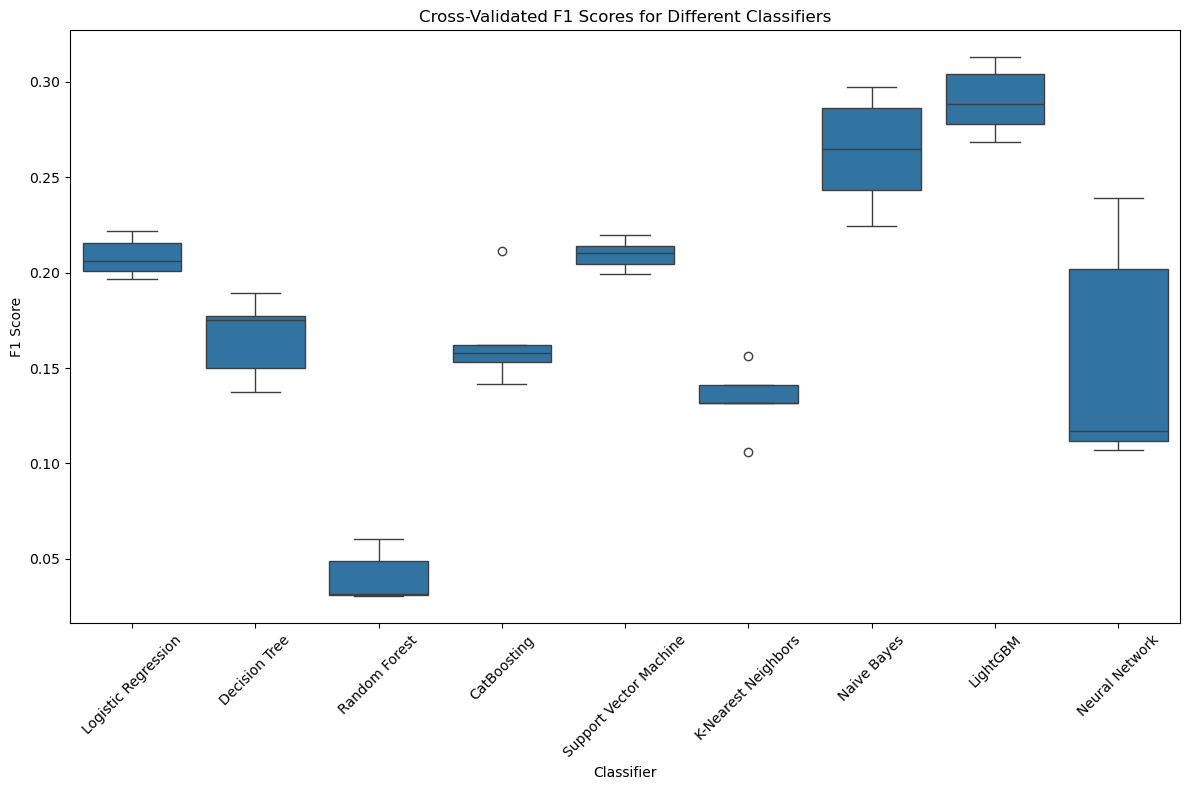

In [27]:
results_df = pd.DataFrame(results)
results_melted = results_df.melt(var_name="Classifier", value_name="F1 Score")

plt.figure(figsize=(12, 8))
sns.boxplot(x="Classifier", y="F1 Score", data=results_melted)
plt.title("Cross-Validated F1 Scores for Different Classifiers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

LightGBM seems to be the most promising. But no result is great.

## Baseline Model

In [28]:
# Base model
lgb = LGBMClassifier(is_unbalance=True)
lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 928, number of negative: 25199
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 26127, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035519 -> initscore=-3.301528
[LightGBM] [Info] Start training from score -3.301528


LGBMClassifier(is_unbalance=True)

# Feature Importance

In [ ]:
result = permutation_importance(
    lgb,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=2,
    scoring=f1_scorer,
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

# Plot permutation importances
fig, ax = plt.subplots()
importances.plot.box(
    vert=False,
    whis=10,
    ax=ax,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", color="blue"),
    medianprops=dict(color="red", linewidth=2),
    meanprops=dict(marker="o", markerfacecolor="black", markeredgecolor="black"),
)

# Adding a mean line
for i in range(importances.shape[1]):
    mean_value = importances.iloc[:, i].mean()
    ax.plot(mean_value, i, "o", color="black")

ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in F1 score")
ax.figure.tight_layout()

plt.show()

In [29]:
y_pred = lgb.predict(X_test)

In [30]:
f1_score(y_test, y_pred)

0.31061259706643657

Next, we will tune our hyperparameters using optuna. But first, we create a Mlflow experiment to keep track of our results.

In [ ]:
# client = MlflowClient()
# client.create_experiment('steam-classification-model')

In [ ]:
# # Verify the active experiment
# active_experiment = client.get_experiment_by_name('steam-classification-model')
# if not active_experiment:
#     raise ValueError(f"Experiment '{'steam-classification-model'}' does not exist.")

In [ ]:
# mlflow.set_experiment('985439486467016955')

2024/06/20 16:58:30 INFO mlflow.tracking.fluent: Experiment with name '985439486467016955' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/matheus/Projects/steam_analysis/steam-analysis/mlruns/553479088872571911', creation_time=1718913510222, experiment_id='553479088872571911', last_update_time=1718913510222, lifecycle_stage='active', name='985439486467016955', tags={}>

In [ ]:
## Code if I need to delete an experiment
# client = MlflowClient()

# experiment_name = "MLflow Quickstart"
# experiment = client.get_experiment_by_name(experiment_name)
# if not experiment:
#     raise ValueError(f"Experiment '{experiment_name}' does not exist.")

# experiment_id = experiment.experiment_id

# runs = client.search_runs(experiment_ids=[experiment_id])

# # Delete all runs
# for run in runs:
#     run_id = run.info.run_id
#     client.delete_run(run_id)
#     print(f"Deleted run with ID: {run_id}")

# print("All runs deleted.")

ValueError: Experiment 'MLflow Quickstart' does not exist.

In [34]:
def objective(trial):
    params = {
        "objective": "binary",
        "boosting_type": "gbdt",
        "max_depth": -1,
        "is_unbalance": True,
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-9, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-9, 10.0, log=True),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "verbosity": -1,
        "n_jobs": -1,
        "random state": 42,
    }

    lgb_opt = LGBMClassifier(**params)
    scoring = make_scorer(f1_score, average="binary")

    cv_score = cross_val_score(
        lgb_opt, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1
    )

    pruning_threshold = 0.30

    # Prune if the average F1 score is below the threshold
    if np.mean(cv_score) < pruning_threshold:
        raise optuna.exceptions.TrialPruned()

    # Log parameters and metrics with MLflow
    with mlflow.start_run(run_name=f"trial_{trial.number}"):
        mlflow.log_params(params)
        mlflow.log_metric("f1", np.mean(cv_score))
    return np.mean(cv_score)

In [35]:
study = optuna.create_study(
    direction="maximize", pruner=optuna.pruners.SuccessiveHalvingPruner()
)
study.optimize(objective, n_trials=200, n_jobs=-1)

[I 2024-06-20 19:00:13,026] A new study created in memory with name: no-name-3b831ef2-f3dd-4248-9030-f93ea1d25ab6
[I 2024-06-20 19:00:25,863] Trial 7 pruned. 
[I 2024-06-20 19:00:45,394] Trial 0 pruned. 
[I 2024-06-20 19:00:50,050] Trial 4 finished with value: 0.3200818619425255 and parameters: {'num_leaves': 252, 'learning_rate': 0.10415613230113265, 'feature_fraction': 0.6836254739801176, 'reg_alpha': 2.9102367593711375e-07, 'reg_lambda': 1.8761610398125447e-09, 'bagging_fraction': 0.6731437838186065, 'bagging_freq': 9, 'min_child_samples': 100}. Best is trial 4 with value: 0.3200818619425255.
[I 2024-06-20 19:01:00,547] Trial 6 finished with value: 0.33008599536319816 and parameters: {'num_leaves': 38, 'learning_rate': 0.01120358512015044, 'feature_fraction': 0.19355833023361518, 'reg_alpha': 5.349777133868339e-09, 'reg_lambda': 1.458836518344801e-09, 'bagging_fraction': 0.9451833666786711, 'bagging_freq': 2, 'min_child_samples': 31}. Best is trial 6 with value: 0.33008599536319816.

In [114]:
best_params = study.best_params
best_params

{'num_leaves': 218,
 'learning_rate': 0.012299865257179486,
 'feature_fraction': 0.7205287309983145,
 'reg_alpha': 5.534157704462869e-06,
 'reg_lambda': 0.008453734323058607,
 'bagging_fraction': 0.7417796313309262,
 'bagging_freq': 4,
 'min_child_samples': 50}

In [26]:
params = {
    "num_leaves": 218,
    "learning_rate": 0.012299865257179486,
    "feature_fraction": 0.7205287309983145,
    "reg_alpha": 5.534157704462869e-06,
    "reg_lambda": 0.008453734323058607,
    "bagging_fraction": 0.7417796313309262,
    "min_child_samples": 50,
}

Now we train our model with the best hyperparameters.

In [27]:
lgb_opt = LGBMClassifier(**params, is_unbalance=True, random_state=42, verbose=-1)
lgb_opt.fit(X_train, y_train)
y_pred = lgb_opt.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.7205287309983145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205287309983145
[LightGBM] [Warning] bagging_fraction is set=0.7417796313309262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417796313309262
[LightGBM] [Warning] feature_fraction is set=0.7205287309983145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205287309983145
[LightGBM] [Warning] bagging_fraction is set=0.7417796313309262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417796313309262
[LightGBM] [Info] Number of positive: 928, number of negative: 25199
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 26127, numbe

In [28]:
f1_score(y_test, y_pred)

0.3594009983361065

In [247]:
y_pred_prob = lgb_opt.predict_proba(X_train)

[LightGBM] [Warning] feature_fraction is set=0.7205287309983145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205287309983145
[LightGBM] [Warning] bagging_fraction is set=0.7417796313309262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417796313309262


Since our classes are heavily unbalaced, we will be using a PR-AUC measure to see if changing the threshold can lead to improved results. 

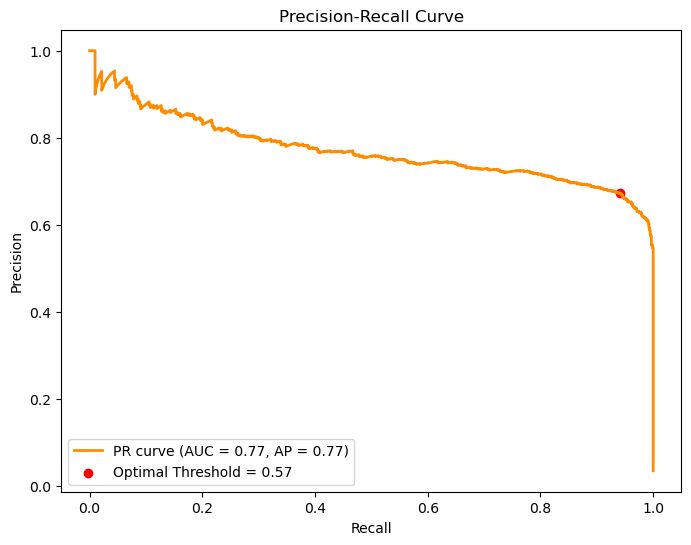

Optimal Threshold: 0.5721598510577628


In [250]:
precision, recall, thresholds = precision_recall_curve(y_train, y_pred_prob[:, 1])

pr_auc = auc(recall, precision)
average_precision = average_precision_score(y_train, y_pred_prob[:, 1])

# Find the optimal point
fscore = (2 * precision * recall) / (precision + recall)
optimal_idx = np.argmax(fscore)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(8, 6))
plt.plot(
    recall,
    precision,
    color="darkorange",
    lw=2,
    label=f"PR curve (AUC = {pr_auc:.2f}, AP = {average_precision:.2f})",
)
plt.scatter(
    recall[optimal_idx],
    precision[optimal_idx],
    marker="o",
    color="red",
    label=f"Optimal Threshold = {optimal_threshold:.2f}",
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

print(f"Optimal Threshold: {optimal_threshold}")

In [251]:
y_pred_prob = lgb_opt.predict_proba(X_test)
threshold = 0.5721598510577628
y_pred_adjusted = (y_pred_prob[:, 1] >= threshold).astype(int)

[LightGBM] [Warning] feature_fraction is set=0.7205287309983145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205287309983145
[LightGBM] [Warning] bagging_fraction is set=0.7417796313309262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417796313309262


In [252]:
f1_score(y_test, y_pred_adjusted)

0.34977578475336324

We get a slightly better result. Let see what it looks like in a Confusion Matrix.

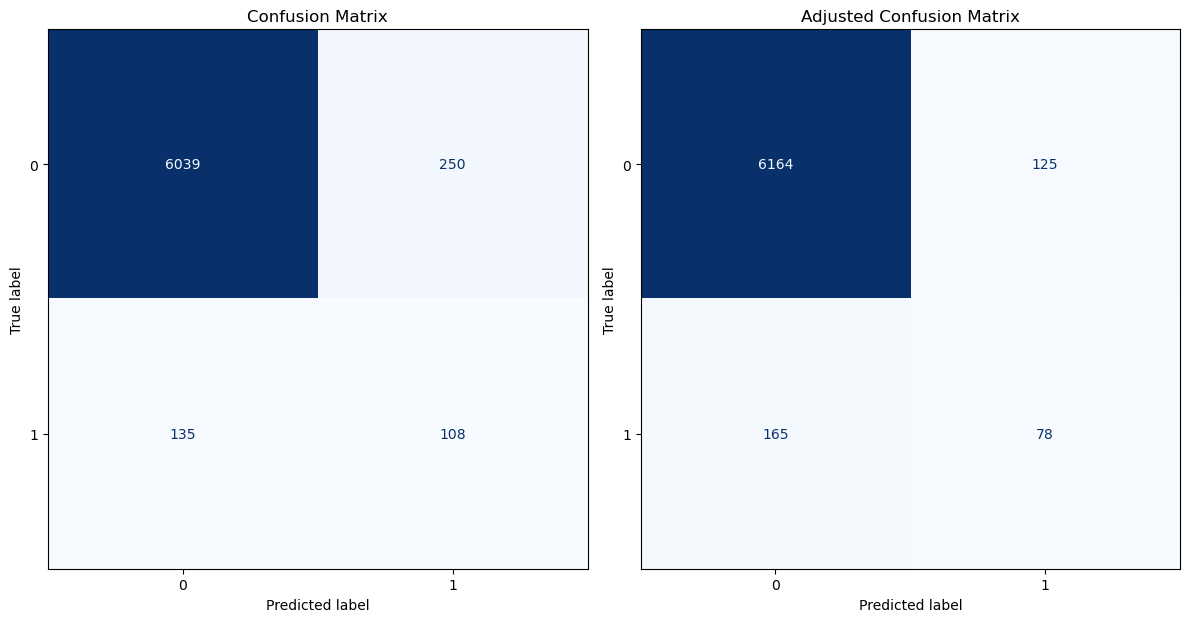

In [277]:
cm1 = confusion_matrix(y_test, y_pred)
cm2 = confusion_matrix(y_test, y_pred_adjusted)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot(cmap=plt.cm.Blues, ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix")

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp2.plot(cmap=plt.cm.Blues, ax=axes[1], colorbar=False)
axes[1].set_title("Adjusted Confusion Matrix")

plt.tight_layout()
plt.show()

## What features are really contributing to the model's generalization?

[LightGBM] [Warning] feature_fraction is set=0.7205287309983145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205287309983145
[LightGBM] [Warning] bagging_fraction is set=0.7417796313309262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417796313309262
[LightGBM] [Warning] feature_fraction is set=0.7205287309983145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205287309983145
[LightGBM] [Warning] bagging_fraction is set=0.7417796313309262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417796313309262
[LightGBM] [Warning] feature_fraction is set=0.7205287309983145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205287309983145
[LightGBM] [Warning] bagging_fraction is set=0.7417796313309262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417796313309262
[LightGBM] [Warning] feature_fraction is set=0.7205287309983145, colsample_bytree=1.0 will be ign

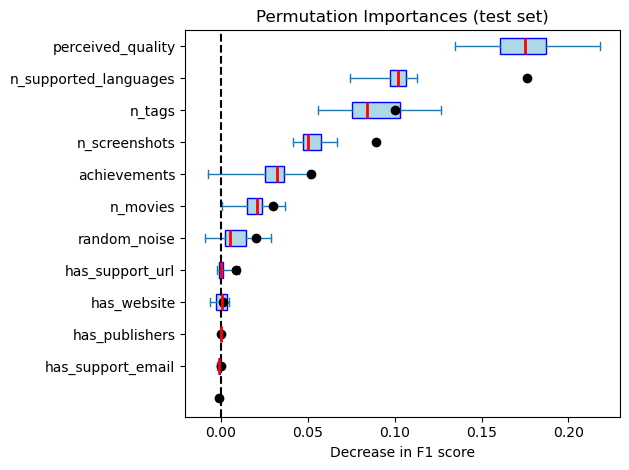

In [29]:
result = permutation_importance(
    lgb_opt,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=2,
    scoring=f1_scorer,
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

# Plot permutation importances
fig, ax = plt.subplots()
importances.plot.box(
    vert=False,
    whis=10,
    ax=ax,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue", color="blue"),
    medianprops=dict(color="red", linewidth=2),
    meanprops=dict(marker="o", markerfacecolor="black", markeredgecolor="black"),
)

# Adding a mean line
for i in range(importances.shape[1]):
    mean_value = importances.iloc[:, i].mean()
    ax.plot(mean_value, i, "o", color="black")

ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in F1 score")
ax.figure.tight_layout()

plt.show()

These results can be interesting from the point of view of model interpretability, but that's not very promising when to making an actual deployable model, since 'perceived_quality' is defined as a ratio between positive and negative reviews, this information won't be available in the moment that the model could be more useful.

## Let's create a trimmed model that could actually be deployed.

In [30]:
trimmed_lgb = lgb_opt.fit(
    X_train[
        ["n_supported_languages", "n_tags", "n_screenshots", "achievements", "n_movies"]
    ],
    y_train,
)

[LightGBM] [Warning] feature_fraction is set=0.7205287309983145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205287309983145
[LightGBM] [Warning] bagging_fraction is set=0.7417796313309262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417796313309262
[LightGBM] [Warning] feature_fraction is set=0.7205287309983145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205287309983145
[LightGBM] [Warning] bagging_fraction is set=0.7417796313309262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417796313309262
[LightGBM] [Info] Number of positive: 928, number of negative: 25199
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 257
[LightGBM] [Info] Number of data points in the train set: 26127, numbe

In [32]:
f1_score(
    y_test,
    trimmed_lgb.predict(
        X_test[
            [
                "n_supported_languages",
                "n_tags",
                "n_screenshots",
                "achievements",
                "n_movies",
            ]
        ]
    ),
)

[LightGBM] [Warning] feature_fraction is set=0.7205287309983145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205287309983145
[LightGBM] [Warning] bagging_fraction is set=0.7417796313309262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417796313309262


0.26713124274099886

[LightGBM] [Warning] feature_fraction is set=0.7205287309983145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205287309983145
[LightGBM] [Warning] bagging_fraction is set=0.7417796313309262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417796313309262


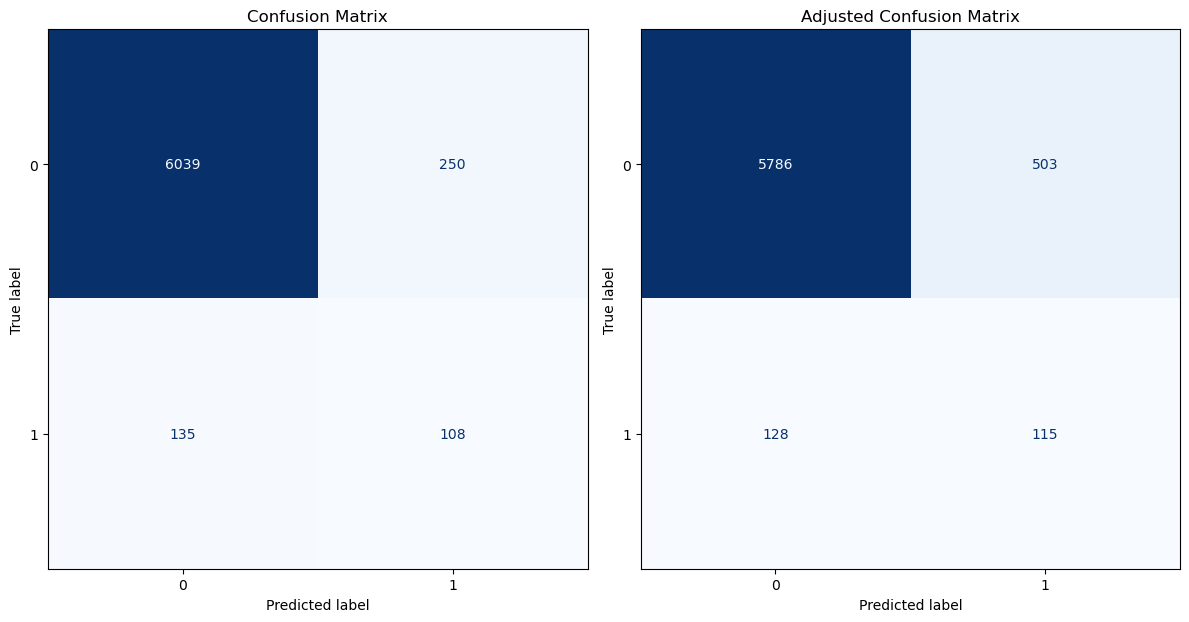

In [33]:
cm1 = confusion_matrix(y_test, y_pred)
cm2 = confusion_matrix(
    y_test,
    trimmed_lgb.predict(
        X_test[
            [
                "n_supported_languages",
                "n_tags",
                "n_screenshots",
                "achievements",
                "n_movies",
            ]
        ]
    ),
)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot(cmap=plt.cm.Blues, ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix")

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp2.plot(cmap=plt.cm.Blues, ax=axes[1], colorbar=False)
axes[1].set_title("Adjusted Confusion Matrix")

plt.tight_layout()
plt.show()

### Model Calibration

In [264]:
platt_calibrated = CalibratedClassifierCV(lgb_opt, method="sigmoid", cv="prefit")
platt_calibrated.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.7205287309983145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205287309983145
[LightGBM] [Warning] bagging_fraction is set=0.7417796313309262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417796313309262


CalibratedClassifierCV(cv='prefit',
                       estimator=LGBMClassifier(bagging_fraction=0.7417796313309262,
                                                feature_fraction=0.7205287309983145,
                                                is_unbalance=True,
                                                learning_rate=0.012299865257179486,
                                                min_child_samples=50,
                                                num_leaves=218, random_state=42,
                                                reg_alpha=5.534157704462869e-06,
                                                reg_lambda=0.008453734323058607))

In [265]:
calibrated_probabilities = platt_calibrated.predict_proba(X_test)

[LightGBM] [Warning] feature_fraction is set=0.7205287309983145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205287309983145
[LightGBM] [Warning] bagging_fraction is set=0.7417796313309262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417796313309262


[LightGBM] [Warning] feature_fraction is set=0.7205287309983145, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205287309983145
[LightGBM] [Warning] bagging_fraction is set=0.7417796313309262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7417796313309262


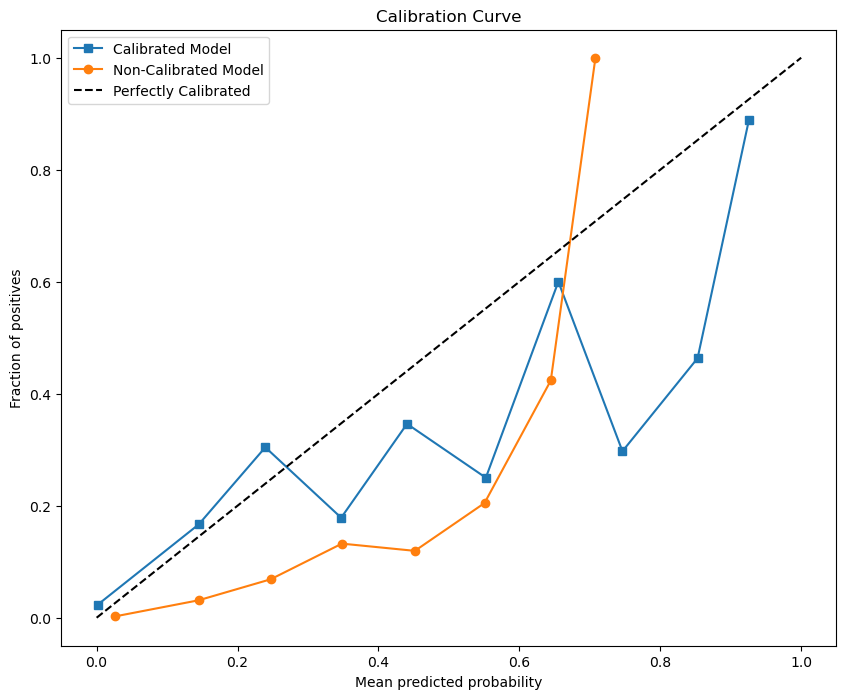

In [274]:
fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(
    y_test, calibrated_probabilities[:, 1], n_bins=10
)
fraction_of_positives_non_cal, mean_predicted_value_non_cal = calibration_curve(
    y_test, lgb_opt.predict_proba(X_test)[:, 1], n_bins=10
)

plt.figure(figsize=(10, 8))
plt.plot(
    mean_predicted_value_cal, fraction_of_positives_cal, "s-", label="Calibrated Model"
)
plt.plot(
    mean_predicted_value_non_cal,
    fraction_of_positives_non_cal,
    "o-",
    label="Non-Calibrated Model",
)
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()